# Lesson 9 Assignment: Naive Bayes

### Author: Dustin Bunrham

1.  Leverage Naïve Bayes algorithm to classify build a model using the data from previous milestones.
2.  Briefly summarize your findings on using Naïve Bayes.
3.  Is Naïve Bayes more accurate than the regression model you used in Milestone 3?

### Data: King County Housing Data Set

The problem I will investigate is how various variables related to housing most affect a houses value.  I will be using king county housing data provided at:
https://library.startlearninglabs.uw.edu/DATASCI410/Handouts/DATASCI%20410%20King%20County%20Housing%20Project.docx

I will begin by doing the following:
1.  Exploring the data for variables of interest using statistics and data visualizations.
2.  Clean the data.
3.  Develop a model using Naive Bayes.
4.  Make predictions of housing prices.
5.  Compare this model to the milestone 3 Regression Model.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
%matplotlib inline
import sklearn.metrics
import sklearn.naive_bayes

In [2]:
# Location of dataset
# King county housing data set
housing = pd.read_csv("kc_house_data.csv")

In [3]:
housing.describe()['price']

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [4]:
# Functions

def normalize(X, names): 
    """
    input: 
        X: Pandas Data Frame that will be min-max normalized
        names: column name
        
    Output:
        Y: Normalized data frame
    """
    N, m = X.shape
    Y = np.zeros([N, m])
    
    for i in range(m):
        name = names[i]
        Y[:,i] = scale(X[name])
    
    return pd.DataFrame(Y, columns=names)

def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

def split_dataset(data, r): # split a dataset in matrix format, using a given ratio for the testing set
    N = len(data)
    X = []
    Y = []
    
    if r >= 1: 
        print ("Parameter r needs to be smaller than 1!")
        return
    elif r <= 0:
        print ("Parameter r needs to be larger than 0!")
        return

    n = int(round(N*r)) # number of elements in testing sample
    ind = -np.ones(n,int) # indexes for testing sample
    R = np.random.randint(N) # some random index from the whole dataset
    
    for i in range(n):
        while R in ind: R = np.random.randint(N) # ensure that the random index hasn't been used before
        ind[i] = R

    ind_ = list(set(range(N)).difference(ind)) # remaining indexes	
    X = data.loc[ind_,:] # training features
    Y = data.loc[ind,:] # testing features

    return X, Y

def replace_outliers(df, col):
    """
    Input: dataframe
    Output: dataframe where the outliers have been replaced by the median of 
    that column.
    
    I will check to see which values meet the conditions that they fall
    between +- 3 standardard deviations of the means.  i will use the tilda
    to pick out the outliers and replace them with the median.
    """
    
    high = np.mean(df[col]) + 3 * np.std(df[col])
    low = np.mean(df[col]) - 3 * np.std(df[col])
    FlagGood = (df.loc[:, col] < high) & (df.loc[:, col] > low)
    df.loc[~FlagGood,col] = np.float("NaN")
    return(df)

def bin_num(col, nbins):
    """
    
    """
    
    bins = np.linspace(min(col), max(col), nbins)
    return(np.digitize(col, bins))

In [5]:
import sklearn.metrics

def confusion_matrix(labels, predicted_labels, label_classes):
    return pd.DataFrame(
        sklearn.metrics.confusion_matrix(labels, predicted_labels),
        index=[label_classes], 
        columns=label_classes)    

def performance(results):
    accuracy = sklearn.metrics.accuracy_score(
        results['party'].cat.codes, results['predicted'].cat.codes)
    precision = sklearn.metrics.precision_score(
            results['party'].cat.codes, results['predicted'].cat.codes)
    recall = sklearn.metrics.recall_score(
            results['party'].cat.codes, results['predicted'].cat.codes)

    print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))
    
    return confusion_matrix(
        results['party'], 
        results['predicted'], 
        results.party.cat.categories)

## 1. Explore the data:
I'm familiar with the data.

In [6]:
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
housing.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## 2. Clean the data

In [8]:
housing = housing.loc[:,housing.columns[2:]]

In [9]:
# Remove outliers
features = housing.columns
for col in features:
    housing = replace_outliers(housing, col)

In [10]:
# Determine bins of continuous features
housing.nunique()
cont_features = {'price':2,
                 'sqft_living':5, 
                 'sqft_lot':5, 
                 'sqft_above':5, 
                 'sqft_basement':3, 
                 'yr_built':3, 
                 'lat':5, 
                 'long':5, 
                 'sqft_living15':5, 
                 'sqft_lot15':5}

In [11]:
#for col in list(cont_features.keys())[1:]:
#    housing[col] = bin_num(housing[col], cont_features[col])

In [12]:
housing.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,NaN,98125.0,47.7210,-122.319,1690.0,7639.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0


In [13]:
housing = housing.dropna(axis=0)
housing = housing.reset_index()
housing.head()

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
2,3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
3,4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0
4,6,257500.0,3.0,2.25,1715.0,6819.0,2.0,0.0,0.0,3.0,7.0,1715.0,0.0,1995.0,0.0,98003.0,47.3097,-122.327,2238.0,6819.0


### Thoughts:
I will split the price into two categories.  Greater to or less than $700,000 in price.  This is relatively arbitrary, and in general just wanted to see whether the model can predict whether a house is upper or lower in price.

In [14]:
# Turn price into categorical variable.  700k cutoff.
for i in range(len(housing)):
    if housing.loc[i, 'price'] >= 700000:
        housing.loc[i, 'price'] = '>=700k'
    else:
        housing.loc[i, 'price'] = '<700k'
        
housing['long'] = -1 * housing.long

## 3. Develop a model using Naive Bayes

In [15]:
# Split data using 70-30 train-test split.
r = 0.3
train, test = split_dataset(housing, r)
train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13091 entries, 1 to 18701
Data columns (total 20 columns):
index            13091 non-null int64
price            13091 non-null object
bedrooms         13091 non-null float64
bathrooms        13091 non-null float64
sqft_living      13091 non-null float64
sqft_lot         13091 non-null float64
floors           13091 non-null float64
waterfront       13091 non-null float64
view             13091 non-null float64
condition        13091 non-null float64
grade            13091 non-null float64
sqft_above       13091 non-null float64
sqft_basement    13091 non-null float64
yr_built         13091 non-null float64
yr_renovated     13091 non-null float64
zipcode          13091 non-null float64
lat              13091 non-null float64
long             13091 non-null float64
sqft_living15    13091 non-null float64
sqft_lot15       13091 non-null float64
dtypes: float64(18), int64(1), object(1)
memory usage: 2.1+ MB


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5611 entries, 2101 to 3186
Data columns (total 20 columns):
index            5611 non-null int64
price            5611 non-null object
bedrooms         5611 non-null float64
bathrooms        5611 non-null float64
sqft_living      5611 non-null float64
sqft_lot         5611 non-null float64
floors           5611 non-null float64
waterfront       5611 non-null float64
view             5611 non-null float64
condition        5611 non-null float64
grade            5611 non-null float64
sqft_above       5611 non-null float64
sqft_basement    5611 non-null float64
yr_built         5611 non-null float64
yr_renovated     5611 non-null float64
zipcode          5611 non-null float64
lat              5611 non-null float64
long             5611 non-null float64
sqft_living15    5611 non-null float64
sqft_lot15       5611 non-null float64
dtypes: float64(18), int64(1), object(1)
memory usage: 920.6+ KB


In [18]:
train.head()

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,2,<700k,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,122.233,2720.0,8062.0
2,3,<700k,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,122.393,1360.0,5000.0
3,4,<700k,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,122.045,1800.0,7503.0
4,6,<700k,3.0,2.25,1715.0,6819.0,2.0,0.0,0.0,3.0,7.0,1715.0,0.0,1995.0,0.0,98003.0,47.3097,122.327,2238.0,6819.0
6,8,<700k,3.0,1.00,1780.0,7470.0,1.0,0.0,0.0,3.0,7.0,1050.0,730.0,1960.0,0.0,98146.0,47.5123,122.337,1780.0,8113.0


In [19]:
# Turn objects into category
for c in train.columns:
    if train[c].dtype == 'object':
        train[c] = train[c].astype('category')

# Turn price into dummy variable
price_label_col = 'price'
price_labels = train[price_label_col].cat.codes

# Append values of numeric variables, or dummy variables of categorical.
features = []
for col in train.columns:
    if col != price_label_col:
        if str(train[col].dtype) == 'category':
            features.append(train[col].cat.codes)
        else:
            features.append(train[col])
price_features_vec = np.array(features).T

# Create the model
model = sklearn.naive_bayes.MultinomialNB(alpha=3)
model.fit(price_features_vec, price_labels)

MultinomialNB(alpha=3, class_prior=None, fit_prior=True)

In [20]:
# Conditional probabilities
conditional_probas = pd.DataFrame(model.feature_log_prob_, columns=test.columns[:-1])
conditional_probas

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15
0,-2.521418,-10.631021,-11.139443,-4.315682,-2.666938,-11.447260,-20.021904,-14.526103,-10.582040,-9.818571,-4.457081,-6.341715,-4.222614,-20.021904,-0.315621,-7.947391,-7.003300,-4.316273,-2.737424
1,-2.551855,-10.533840,-10.932108,-3.925864,-2.466297,-11.314532,-18.381993,-13.334277,-10.615012,-9.699060,-4.059110,-6.007304,-4.277330,-18.381993,-0.372353,-8.002360,-7.060115,-4.024549,-2.583433


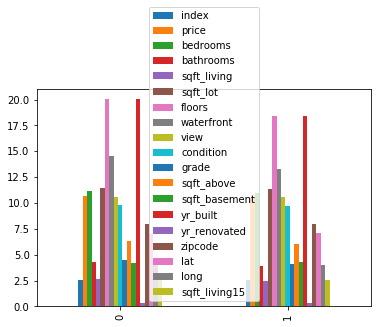

In [21]:
(-conditional_probas).plot(kind = 'bar')

### Thoughts:
As expected the two heavy predictors are floors and bathrooms.

In [22]:
# Format the test data
for c in test.columns:
    if test[c].dtype == 'object':
        test[c] = test[c].astype('category')
        
price_labels_test = test[price_label_col].cat.codes

features_test = []
for col in test.columns:
    if col != price_label_col:
        if str(test[col].dtype) == 'category':
            features_test.append(test[col].cat.codes)
        else:
            features_test.append(test[col])
price_features_vec_test = np.array(features_test).T

## 4.  Make predictions using the model

In [23]:
# Make predictions
predicted_price = model.predict(price_features_vec_test)
income_probabilities = model.predict_proba(price_features_vec_test)

# Measures of model
accuracy = sklearn.metrics.accuracy_score(price_labels_test, predicted_price)
precision = sklearn.metrics.precision_score(price_labels_test, predicted_price)
recall = sklearn.metrics.recall_score(price_labels_test, predicted_price)
print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))
print('Confusion matrix:')
confusion_matrix(price_labels_test, predicted_price, 
                 test[price_label_col].cat.categories)

Accuracy = 0.763, Precision = 0.319, Recall = 0.448
Confusion matrix:


,<700k,>=700k
<700k,3889,843
>=700k,485,394


## 5.  Compare this model to the milestone 3 Regression Model.

This model does an ok job of predicting whether a house costs more or less than 700k.  I thought it would do better than it actually did.  I don't think comparing this model to my milestone 3 results would appropriate considering the model predicts a categorical variable, while the other predicts a numeric price based on an PCA regression model.  The R-squared of my previous milestones has been around 0.7, and the accuracy of this model is around 76.3%.  Despite this large accuracy, I have reservations about this model because of the low recall and precision.  The low precision and recall show that the classification model is lacking.  In general I would prefer a regression model for this type of predicting.